## Train Base Model -- Development of a Transaction Categorization Model

This notebook aims to create the base model to categorize transactions. In this scenario, all categories will have the same importance, adjusted by the frequency.

### Tasks:
 - [X] Load training dataset.
 - [X] Create k folds for experiments.
 - [X] Generate feature vector.
 - [X] Train model.
     - [X] Adjust weights;
     - [X] Compute metrics based on folds;
     - [X] Train final model;
 - [X] Submit model, parameters and metrics do MLflow.

## Libraries and Configurations

In [1]:
import copy
from operator import itemgetter

import pandas as pd
from lightgbm.sklearn import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from application.code.core.configurations import configs
from application.code.adapters.storage import read_dataset
from application.code.core.dataset_split_service import generate_folds, describe_datasets
from application.code.core.feature_engineering import engineer_features, standardize_labels
from application.code.core.model_training_service import train_model
from application.code.core.model_training import (clean_data,
                                                  vectorize_folds,
                                                  compute_weights,
                                                  generate_encoders,
                                                  vectorize_dataset,
                                                  combine_feature_columns)
from application.code.core.model_evaluation import (compute_multiclass_classification_metrics,
                                                    generate_classification_report,
                                                    generate_feature_importance_report,
                                                    generate_confusion_matrix_report,
                                                    generate_labels_support,
                                                    plot_folds_metrics)
from application.code.adapters.mlflow_adapter import (log_dataframe_artifact, 
                                                      get_mlflow_artifact_content,
                                                      log_model,
                                                      register_model,
                                                      publish_model)
from application.code.core.financial_classification_model import FinancialClassificationModel

sns.set_style("whitegrid")

## Constants

In [2]:
BASE_MODEL_PARAMS = {
    'objective': 'multiclass', 
    'metric': 'multi_error',
    'verbosity': -1, 
    'n_estimators': 500,
    'random_state': configs.model_training.model_seed,
    'deterministic': True
}

TARGET_COLUMN = 'grupo_estabelecimento'

CATEGORICAL_COLUMNS = ['cidade', 'estado', 'sexo', 
                       'cidade_estabelecimento','pais_estabelecimento']

HIGH_CARDINALITY_CATEGORICAL_COLUMNS = [
    'cidade', 'estado', 
    'cidade_estabelecimento', 'pais_estabelecimento', 'estado_estabelecimento',
]

BINARY_COLUMNS = ['sexo',  'dia_util',
                  'cidade_diferente', 'estado_diferente', 'pais_diferente',]

NUMERIC_COLUMNS = ['idade',
                   'limite_total', 'limite_disp', 'valor', 
                   'dia_semana', 'dia_mes', 'mes',
                   'valor_relativo_total', 'valor_relativo_disponivel',
                  ]

COLUMNS_SELECTION  = combine_feature_columns(HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                             BINARY_COLUMNS,
                                             NUMERIC_COLUMNS)

EXPERIMENT_RUN_NAME = 'Base Model'

## MLflow Settings

In [3]:
mlflow.set_tracking_uri(configs.mlflow.uri)
mlflow.set_experiment(configs.mlflow.experiment_name);

## Load Dataset

The `training` dataset is loaded to create the model perform experiments.

In [4]:
df = read_dataset(base_path=configs.datasets.base_path, stage='raw', file_name='train')

display(HTML('<h4>Dataset</h4>'))
print(f'Records: {len(df)}')

Records: 3944


To create the model and perform experiments, only the `training` dataset will be used. The evaluation will be performed by creating some time-oriented `validation` datasets using the same methodology used to create the `test` dataset.

3 sets of `training` and `validation` sets will be created, each of them representing a fold. At the end, it will be possible to have an efficacy measurement with a variance notion.
It is important to use `validation` set avoid using the `test` several times. Ideally, it should be used only once, for the final assessment.

In [5]:
folds = generate_folds(df,
                       n_folds=configs.model_training.folds,
                       min_validation_size=configs.model_training.min_validation_size,
                       seed=configs.model_training.data_seed)

Summarize and validate folds (`training` and `validation` sets should not share records).

In [6]:
for ix, (train_df, valid_df) in enumerate(folds):

    display(HTML(f'<strong>Fold <code>{ix}</code></strong>'))
    describe_datasets(train_df, valid_df, TARGET_COLUMN)
    print()

    train_periods = set(train_df["period"].tolist())
    valid_periods = set(valid_df["period"].tolist())

    assert len(train_periods & valid_periods) == 0, \
    'Training and Validation share dates.'

 - Split Period: 2019-12-31
 - Training:
	 - Size: 3533
	 - Days: 274
	 - Labels: 21
 - Assessment:
	 - Size: 27
	 - Days: 27
	 - Labels: 18
 - Assessment Relative Size: 10.42%



 - Split Period: 2019-12-03
 - Training:
	 - Size: 3108
	 - Days: 246
	 - Labels: 21
 - Assessment:
	 - Size: 28
	 - Days: 28
	 - Labels: 19
 - Assessment Relative Size: 12.03%



 - Split Period: 2019-11-06
 - Training:
	 - Size: 2679
	 - Days: 219
	 - Labels: 21
 - Assessment:
	 - Size: 27
	 - Days: 27
	 - Labels: 18
 - Assessment Relative Size: 13.80%



 - Split Period: 2019-10-04
 - Training:
	 - Size: 2243
	 - Days: 186
	 - Labels: 20
 - Assessment:
	 - Size: 33
	 - Days: 33
	 - Labels: 17
 - Assessment Relative Size: 16.27%



 - Split Period: 2019-08-27
 - Training:
	 - Size: 1826
	 - Days: 148
	 - Labels: 20
 - Assessment:
	 - Size: 38
	 - Days: 38
	 - Labels: 18
 - Assessment Relative Size: 18.59%



## Dataset Preprocessing and Feature Vectorization

Vectorization of each fold based on the following strategy:
 - For each fold:
   - Perform basic cleaning:
       - Remove duplicated records.
       - Format column names.
       - Cast column types.
       - Standardize string values.
   - Create new features based on the orignal features.
   - Use the `training` set to create encoders (label and categorical columns);
       - `LabelEncoder` represents target labels into numbers.
       - `CountEncoder` represents high cardinality categorical data into numbers -- This method deals with missing values and avoid the need to create multiple columns to represent the values, reducing the sparsity of the feature vector.
    - Transform binary columns into `0` or `1`
   
The value are not scaled due to the use of a tree-based algorithm (LightGBM), which is not sensitive to feature scale -- [besides some evidences possibilities](https://arxiv.org/pdf/1611.04561.pdf).


In [7]:
vectorized_folds = vectorize_folds(folds,
                                   columns_selection=COLUMNS_SELECTION,
                                   categorical_columns=CATEGORICAL_COLUMNS,
                                   high_cardinality_categorical_columns=HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
                                   binary_columns=BINARY_COLUMNS,
                                   target_column=TARGET_COLUMN,
                                  )

## Model Training on Folds

As stated before, LightGBM will be used as algorithm to learn a model. It was chosen because:
 - Is based on trees and does not require scalling features.
 - Has good results on Industry and at Machine Learning competitions.
 - Is able to deal with missing values.
 - Has good efficiency and support for high volume of data (using GPU or distributed computing). 
 - Provides an API compatible with SKlearn.
 - Has a good [documentation](https://lightgbm.readthedocs.io/en/v3.3.2/) and community content (e.g., blogs and forums).
 - Is supported by different ML tools (e.g., Optuna, ONNX, Dask, and Spark)

### Training and Evaluation on Folds

For each fold (a pair of `training` and `validation` sets), the steps performed are:
 - Compute *class weights* to make all records have the same importance for the model -- which is a strategy to fix the unbalancing problem without the need to generate synthetic data.
 - Train the model.
 - Make predictions based on the validation data.
 - Compute evaluation metrics based on validation labels.
 - Record resources to analyze.

In [8]:
%%time

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

iterations_tracking = []
resources = []

for ix, ((train_X, train_y), (valid_X, valid_y), labels) in enumerate(vectorized_folds):

    class_weights = compute_weights(train_y)

    model_params.update({'class_weight': class_weights,
                         'num_class': len(set(train_y))})

    model = LGBMClassifier(**model_params)
    model.fit(train_X, train_y)

    preds = model.predict(valid_X)
    eval_metrics = compute_multiclass_classification_metrics(valid_y, 
                                                             preds)

    iteration_tracking = {**{'Fold': ix,
                             'training_size': train_X.shape[0],
                             'validation_size': valid_X.shape[0],},
                          **eval_metrics}
    iterations_tracking.append(iteration_tracking)    

    resources.append({'model': model,
                      'preds': preds,
                      'y': valid_y,
                      'labels': labels
                     })

CPU times: user 5min 31s, sys: 2.03 s, total: 5min 33s
Wall time: 47.7 s


### Folds Metrics

Considering the unbalance of the labels, it is important to consider metrics that are not sensitive to it. For that purpose, `Precision`, `Recall`, and `F1` are good alternatives to provide information about each class. `Accuracy` might not be the best to be affected by the unbalance -- although, there are `balanced` versions of it that could be used.


The selected metrics are computed with three [average strategies available at Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score):
 - `micro`: Calculate metrics globally by counting the total true positives, false negatives and false positives.
 - `macro`: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
 - `weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

,Fold,training_size,validation_size,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,weighted_precision,weighted_recall,weighted_f1
0,0,3533,411,0.155023,0.138642,0.141495,0.406326,0.406326,0.406326,0.387685,0.406326,0.391448
1,1,3108,425,0.315095,0.273871,0.283400,0.423529,0.423529,0.423529,0.445646,0.423529,0.423123
2,2,2679,429,0.294384,0.312497,0.293365,0.403263,0.403263,0.403263,0.395794,0.403263,0.397714
3,3,2243,436,0.294458,0.290459,0.283728,0.444954,0.444954,0.444954,0.441805,0.444954,0.433944
4,4,1826,417,0.247955,0.254468,0.227668,0.482014,0.482014,0.482014,0.470008,0.482014,0.463236


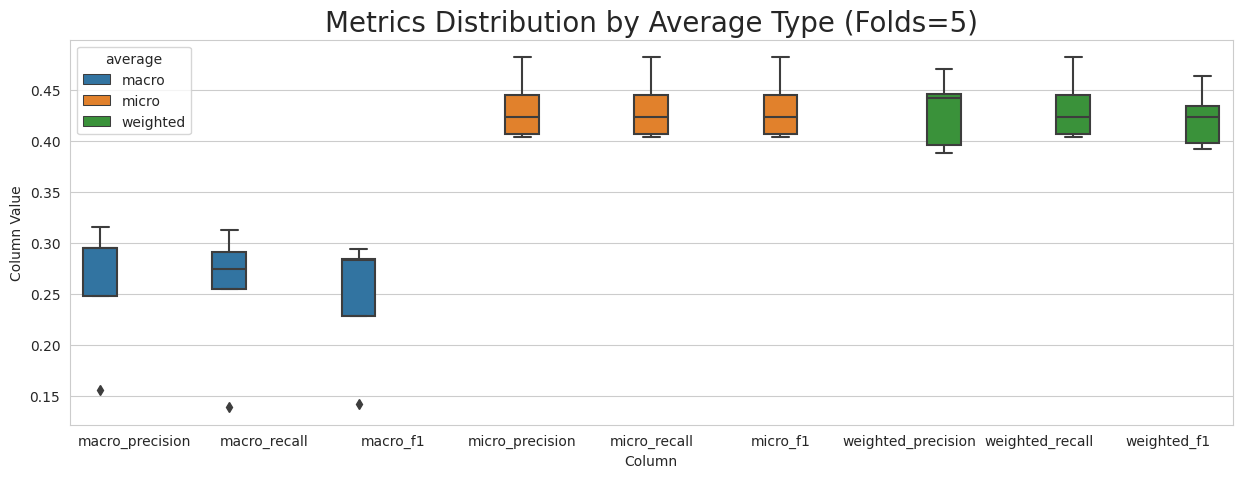

,mean,std
macro_precision,0.261383,0.064344
macro_recall,0.253987,0.067922
macro_f1,0.245931,0.063880
micro_precision,0.432017,0.032504
micro_recall,0.432017,0.032504
micro_f1,0.432017,0.032504
weighted_precision,0.428188,0.035103
weighted_recall,0.432017,0.032504
weighted_f1,0.421893,0.029015


In [9]:
folds_evaluation_df = pd.DataFrame(iterations_tracking)

display(HTML('<h4>Individual Folds Results</h4>'))
display(folds_evaluation_df)

plot_folds_metrics(folds_evaluation_df)

display(HTML('<strong>Summarized Fold Metrics</strong>'))
summarized_validation_metrics_df = (
    folds_evaluation_df
    .drop(columns=['Fold', 'training_size', 'validation_size'])
    .agg(['mean', 'std'])
    .T
)
display(summarized_validation_metrics_df)

It is possible to observe that:
 - `macro` average penalizes the model due to the absence or low number of records related to most of the classes and the dataset umbalance.
 - `micro` average shows that, in average, the model predicts almost 45% of the correct labels.
 - `weighted` average shows a slightly improvement over the `micro` average, probably because the model is correctly predicting the most frequent classes and the weighting is increasing the metric.
 
For this scenario, `micro` average seems to be relevant for the overwall model performance, while the `weighted` average computes the performance considering the most frequent classes.

### Detailing Largets Fold Results

The time-based cross-validation allows identifying the behavior along different periods of time. The latest fold, in addition to being the largest, is the most recent and similar to the final dataset, in which the entire training set is used to create the model and the test set is used to evaluate it. To better understand the model and the performance details, the latest folder will be analized.

#### Model Performance per Class

In [10]:
selected_fold = 0
fold_train_df, _ = folds[selected_fold]
fold_y, fold_preds, fold_labels = itemgetter('y', 'preds', 'labels')(resources[selected_fold])

training_support_df = generate_labels_support(fold_train_df).set_index('grupo_estabelecimento')

classification_report_df = generate_classification_report(fold_y, fold_preds, fold_labels)
(
    classification_report_df
    .join(training_support_df)
    .rename(columns={'support': 'validation_support'})
    .astype({'validation_support': int})
    .sort_values(by='training_support', ascending=False)
    .reset_index()
    .rename(columns={'index': 'class'})
    .style
    .applymap(lambda value: 'background-color:#7fb3d5' if value  > .5 else '',
              subset=['f1-score', 'precision', 'recall'])
    .applymap(lambda value: 'background-color:#d2b4de' if value  == 'vestuário' else '',
             subset=['class'])
    .applymap(lambda value: 'font-weight:bold', subset=['class'])
)

,class,precision,recall,f1-score,validation_support,training_support
0,serviço,0.649007,0.748092,0.695035,131,1324
1,restaurante,0.328358,0.323529,0.325926,68,640
2,varejo,0.222222,0.214286,0.218182,56,391
3,supermercados,0.237288,0.280000,0.256881,50,327
4,vestuário,0.157895,0.166667,0.162162,18,179
5,farmácias,0.000000,0.000000,0.000000,15,150
6,posto de gás,0.714286,0.294118,0.416667,17,141
7,compra online,0.375000,0.473684,0.418605,19,123
8,artigos eletro,0.428571,0.300000,0.352941,10,85
9,loja de departamento,0.142857,0.111111,0.125000,9,55


As the table shows, the only classes with a performance metric above 0.5 are `serviço` and `posto de gás`. While the former has the highest number of records, the later is at the 7th position in number of records. It indicates the issue might not be only abou the sample size to train the records, but also about something else -- which might be data quality, drift, etc. 

Classes with less than 25 training records could not have any positive score. Not only the sample size could be too small, but there is too few or no records to validate them.

As `vestuário` is a class of interest, it is highlighted in lilac. This class F1 is `0.162`, which would be considered too low to be used in production.

### Confusion Matrix

This section shows the confusion matrix for the top 10 classes (based on frequency).

In [11]:
top_labels_df = (df
 .pipe(clean_data, ['grupo_estabelecimento'])  
 [['grupo_estabelecimento']]
 .assign(records=1)
 .groupby('grupo_estabelecimento')
 .sum()
 .reset_index()
 .sort_values(by='records', ascending=False)
 .head(10)
)

display(HTML(f'<strong>Confusion Matrix for Top 10 Categories based on Model for Fold <code>{selected_fold}</code></strong>'))
confusion_matrix_df = generate_confusion_matrix_report(fold_y, fold_preds, fold_labels)

top_labels = set(top_labels_df['grupo_estabelecimento'].tolist())
top_rows_index = sorted(list(top_labels & set(confusion_matrix_df.index)))
top_columns_index = sorted(list(top_labels & set(confusion_matrix_df.columns.tolist())))

(
    confusion_matrix_df
    .loc[top_rows_index, top_columns_index]
)

,artigos eletro,compra online,farmácias,loja de departamento,posto de gás,restaurante,serviço,supermercados,varejo,vestuário
artigos eletro,3,1,0,0,0,1,3,0,1,1
compra online,0,9,0,1,0,1,2,3,2,1
farmácias,0,0,0,1,0,2,4,5,3,0
loja de departamento,0,0,0,1,0,1,3,1,2,0
posto de gás,0,0,1,0,5,3,1,5,2,0
restaurante,0,1,2,0,1,22,13,16,8,2
serviço,0,2,2,1,0,13,98,7,7,1
supermercados,1,2,1,0,0,10,9,14,10,3
varejo,1,6,2,0,0,9,12,6,12,7
vestuário,1,2,0,1,1,1,5,1,3,3


Some interesting points based on the confusion matrix:
 - `serviço` is the most popular category and has the best number of right answers. It "loses" and "gains" predictions from the next top three categories (`restaurante`, `supermercados`, and `varejo`).
 - `restaurante` and `supermercados` seems be similar, based on the false positives exchanged.
 - `vestuario` has a low number of cases, which seems to justify the model's low eficacy. 

## Main Model Training

This section creates the final model, using all the `training` set. The final evaluation will be performed in another notebook, to avoid reusing the `test` set.

In [12]:
%%time

clean_df = (
    df
    .drop_duplicates()
    .pipe(clean_data, CATEGORICAL_COLUMNS + [TARGET_COLUMN])
    .pipe(engineer_features)
)

labels = clean_df[TARGET_COLUMN].unique().tolist()

label_encoder, categorical_encoder = generate_encoders(
    clean_df[COLUMNS_SELECTION],
    labels,
    HIGH_CARDINALITY_CATEGORICAL_COLUMNS,
)

X_training, y_training = vectorize_dataset(df,
                                           label_encoder, 
                                           categorical_encoder,
                                           columns_selection=COLUMNS_SELECTION,
                                           categorical_columns=CATEGORICAL_COLUMNS,
                                           binary_columns=BINARY_COLUMNS,
                                           target_column=TARGET_COLUMN,
                                          )

model_params = copy.deepcopy(BASE_MODEL_PARAMS)

extra_artifacts = [
    (confusion_matrix_df, 'validation folds', 'confusion matrix'),
    (summarized_validation_metrics_df, 'validation folds', 'metrics')
]

mlflow_run, model = train_model(
    algorithm_class=LGBMClassifier,
    model_params=model_params,
    X_training=X_training,
    y_training=y_training,
    experiment_run_name=EXPERIMENT_RUN_NAME,
    extra_artifacts=extra_artifacts,
    features_names=COLUMNS_SELECTION,
    labels=labels
)

CPU times: user 1min 8s, sys: 525 ms, total: 1min 8s
Wall time: 10.6 s


### Model Registration and Publication

After creating the model, it is wrapped into an MLFlow class to be used later.

In [13]:
mlflow_model = FinancialClassificationModel(
    categorical_columns=CATEGORICAL_COLUMNS,
    binary_columns=BINARY_COLUMNS,
    numeric_columns=NUMERIC_COLUMNS,
    label_encoder=label_encoder,
    categorical_encoder=categorical_encoder,
    model=model)

Then, the model should be logged into the experiment, registered at the MLflow Registry and published with the `Staging` tag.

In [14]:
log_model(mlflow_model, mlflow_run, configs.mlflow.base_model_name)
model_version = register_model(mlflow_run, configs.mlflow.base_model_name)
publish_model(model_name=configs.mlflow.base_model_name, 
              model_version=model_version, 
              stage="Staging")

2022/08/27 12:45:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: financial_categorization_model, version 36


### Model Artifacts

A set of reports are save on MLFlow to track the experiment. As the final assessment will be performed only at the end, the metrics are computed based on the training data. While it is not a good indicative of generalization capacity of the model, it helps validating that the model is able to learn the patterns from the training set. It is expected that almost all metrics will have a perfect score, especially when using a boosting algorithm.

In [15]:
main_model_artifacts = get_mlflow_artifact_content(mlflow_run.info.run_id, 'main model')

for artifact_name, content in main_model_artifacts.items():
    display(HTML(f'<h4>{artifact_name.capitalize()}</h4>'))
    display(HTML(main_model_artifacts[artifact_name]))

,feature,absolute_importance,relative_importance
16,valor,27914,17.37%
10,limite_disp,22425,13.96%
18,valor_relativo_total,22310,13.89%
17,valor_relativo_disponivel,21426,13.34%
3,dia_mes,17390,10.82%
12,mes,9855,6.13%
4,dia_semana,9109,5.67%
2,cidade_estabelecimento,9081,5.65%
9,idade,7986,4.97%
11,limite_total,7210,4.49%


,metric,value
0,macro_precision,1.0
1,macro_recall,1.0
2,macro_f1,1.0
3,micro_precision,1.0
4,micro_recall,1.0
5,micro_f1,1.0
6,weighted_precision,1.0
7,weighted_recall,1.0
8,weighted_f1,1.0


,class,weight
0,0,31.301587
1,1,187.809524
2,2,1.976942
3,3,15.650794
4,4,6.260317
5,5,1.322602
6,6,1.138240
7,7,11.738095
8,8,8.943311
9,9,37.561905


,precision,recall,f1-score,support
serviço,1.0,1.0,1.0,6.0
farmácias,1.0,1.0,1.0,1.0
compra online,1.0,1.0,1.0,95.0
artigos eletro,1.0,1.0,1.0,12.0
varejo,1.0,1.0,1.0,30.0
loja de departamento,1.0,1.0,1.0,142.0
vestuário,1.0,1.0,1.0,165.0
móveis e decoração,1.0,1.0,1.0,16.0
hospitais e clínicas,1.0,1.0,1.0,21.0
sem ramo,1.0,1.0,1.0,5.0


## Concluding Remarks
 - Effectiveness:
     - The F1 performance on the `validation folds` are low (about 45% of F1, based on micro average). The main reason might be related to the unbalance and low frequency of some categories and dataset unbalance.
     - The most recent fold has the second worst performance. That is curious because it has the highest ammount of training data.
     - The best performance was on the last fold, with the least ammount of data. That might be an indicative that it is important to keep only recent data with respect to the prediction data. It can be achieved by restrincting the training window of data or reducing the weights of old data.
     - Only two classes (`serviço` and `posto de gás`) presented F1 score higher than `0.5` on the largest fold.
 - Features:
     - Features based on `valor` and `limite` are the most important for the algorithm.
     - From the new feature created, `dia_mes` and `mes` were the most relevant. That is interesting for the final assessment because the dataset contains only 1 year of data. The test set will not have data with known months at the training set.
     - There are 7 features with less than 1% of relative importance. 
 
 - Overwall:
     - As there is a limited number of records related to the less frequent categories, an alternative approach would be grouping all of them into a `others` group. 
 
 
Some alternative approaches could be experimented:
 - Perform hyperparameters tuning using [Optuna](https://optuna.org/).
 - Make older data less relevant by decreasing the weights of each record based on time.
 - Use [alternative encoders](https://contrib.scikit-learn.org/category_encoders) for high cardinality categories. `Catboost` and `LeaveOneOut` are some of the notable candidates.
 - Apply alternative classification algorithms to improve results (e.g., Neural Networks and [CatBoost](https://catboost.ai/)).
 - Eliminate noisy or conflicting data by using techniques such as [Tomek Links](https://imbalanced-learn.org/stable/under_sampling.html#tomek-links).
 - Perform adversarial validation to check drift between `training` and `assessment` datasets.
 - Use SHAP to compute feature importance in a more reliable way.